# Concise Implementation of Linear Regression

In [1]:
!pip install torch torchvision

In [2]:
!pip install -U d2l

     |████████████████████████████████| 82 kB 709 kB/s 
     |████████████████████████████████| 9.9 MB 58.9 MB/s 
     |████████████████████████████████| 61 kB 6.7 MB/s 
     |████████████████████████████████| 11.2 MB 13.4 MB/s 
     |████████████████████████████████| 900 kB 36.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you h

## Generating the Dataset

In [4]:
# generate the same dataset as in Section 3.2

import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

## Reading the Dataset

Rather than rolling our own iterator, we can call upon the existing API in a framework to read data. We pass in features and labels as arguments and specify batch_size when instantiating a data iterator object. Besides, the boolean value is_train indicates whether or not we want the data iterator object to shuffle the data on each epoch (pass through the dataset).

In [6]:
def load_array(data_arrays, batch_size, is_train=True):  #save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

Now we can use **data_iter** in much the same way as we called the **data_iter** function in Section 3.2. To verify that it is working, we can read and print the first minibatch of examples. Comparing with Section 3.2, here we use **iter** to construct a Python iterator and use **next to** obtain the first item from the iterator.

In [7]:
next(iter(data_iter))

[tensor([[-0.5626, -0.4372],
         [ 1.3991, -0.1212],
         [ 0.1802, -0.1202],
         [ 0.7499,  0.7628],
         [-1.8661,  0.5317],
         [ 0.1317,  0.5105],
         [-0.2978, -0.1656],
         [-0.2598,  0.2131],
         [ 0.7396, -0.1628],
         [ 0.8332,  1.1624]]), tensor([[ 4.5484],
         [ 7.4225],
         [ 4.9678],
         [ 3.0946],
         [-1.3308],
         [ 2.7291],
         [ 4.1765],
         [ 2.9392],
         [ 6.2246],
         [ 1.9286]])]

## Defining the Model

When we implemented linear regression from scratch in **Section 3.2, we defined our model parameters explicitly and coded up the calculations to produce output using basic linear algebra operations**. You should know how to do this. But once your models get more complex, and once you have to do this nearly every day, you will be glad for the assistance. The situation is similar to coding up your own blog from scratch. Doing it once or twice is rewarding and instructive, but you would be a lousy web developer if every time you needed a blog you spent a month reinventing the wheel.

For standard operations, we can use a framework’s predefined layers, which allow us to focus especially on the layers used to construct the model rather than having to focus on the implementation. We will first define a model variable **net**, which will refer to an instance of the **Sequential** class. The **Sequential** class defines a container for several layers that will be chained together. Given input data, a **Sequential** instance passes it through the first layer, in turn passing the output as the second layer’s input and so forth. In the following example, our model consists of only one layer, so we do not really need **Sequential**. But since nearly all of our future models will involve multiple layers, we will use it anyway just to familiarize you with the most standard workflow.

**Recall the architecture of a single-layer network as shown in Fig. 3.1.2**. The layer is said to be fully-connected because **each of its inputs is connected to each of its outputs** by means of a **matrix-vector multiplication**.

In [10]:
# In PyTorch, the fully-connected layer is defined in the Linear class.
# Note that we passed two arguments into nn.Linear.
# The first one specifies the input feature dimension, which is 2
# the second one is the output feature dimension, which is a single scalar and therefore 1

# `nn` is an abbreviation for neural networks
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

## Initializing Model Parameters

Before using **net**, we need to initialize the model parameters, such as the weights and bias in the linear regression model. Deep learning frameworks often have a predefined way to initialize the parameters. Here we specify that each weight parameter should be randomly sampled from a normal distribution with mean 0 and standard deviation 0.01. The bias parameter will be initialized to zero.



As we have specified the input and output dimensions when constructing **nn.Linear**, now we can access the parameters directly to specify their initial values. We first locate the layer by **net[0]**, which is the first layer in the network, and then use the **weight.data** and **bias.data** methods to access the parameters. Next we use the replace methods **normal_** and **fill_** to overwrite parameter values.

In [11]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## Defining the Loss Function

In [12]:
# The MSELoss class computes the mean squared error 

loss = nn.MSELoss()

## Defining the Optimization Algorithm

**Minibatch stochastic gradient descent is a standard tool for optimizing neural networks** and thus PyTorch supports it alongside a number of variations on this algorithm in the **optim** module. When we instantiate an SGD instance, we will specify the parameters to optimize over (obtainable from our net via **net.parameters**()), with a dictionary of hyperparameters required by our optimization algorithm. Minibatch stochastic gradient descent just requires that we set the value **lr**, which is set to **0.03** here.

In [13]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## Training

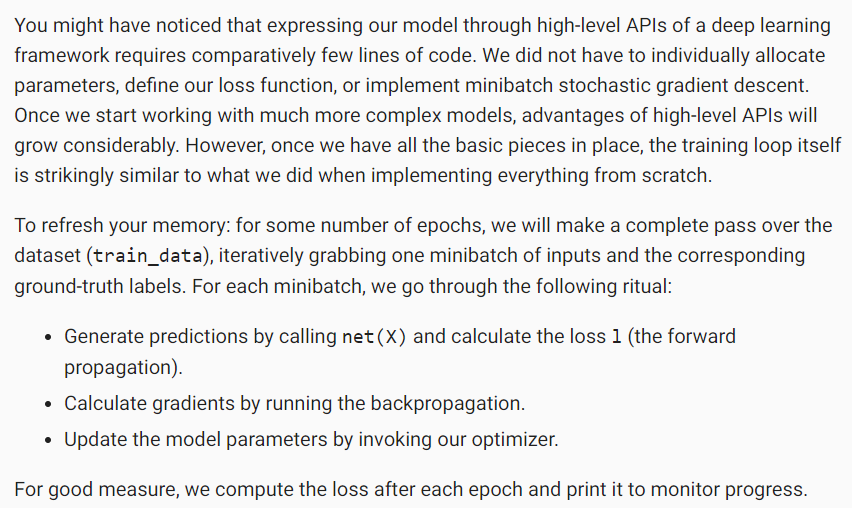

In [14]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000308
epoch 2, loss 0.000103
epoch 3, loss 0.000103


Below, we compare the model parameters learned by training on finite data and the actual parameters that generated our dataset. To access parameters, we first access the layer that we need from **net** and then access that layer’s weights and bias. As in our from-scratch implementation, note that our estimated parameters are close to their ground-truth counterparts.

In [15]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([ 0.0002, -0.0010])
error in estimating b: tensor([-0.0005])


## Summary



*   Using PyTorch’s high-level APIs, we can implement models much more concisely.


*   In PyTorch, the data module provides tools for data processing, the nn module defines a large number of neural network layers and common loss functions.


*   We can initialize the parameters by replacing their values with methods ending with _.





